In [ ]:
import os
dirs=os.listdir(r"/DIR/CSVs_CrowdTangle")
for i in dirs:
  print(i)

VVD.csv
SP.csv
SGP.csv
Wopke-Hoekstra (CDA).csv
Thierry-Baudet (FVD).csv
Mark-Rutte-VVD.csv
Joost-Eerdmans (JA21).csv
Sigrid-Kaag (D66).csv
Mirjam-Bikker (CU).csv
Kees-van-der-Staaij (SGP).csv
JA21.csv
Jesse-Klaver (Groenlinks).csv
GroenLinks.csv
Farid-Azarkan (DENK).csv
D66.csv
ChristenUnie.csv
Attje-Kuiken (PvdA).csv
CDA.csv
PvdD.csv
PvdA.csv
Volt-Nederland.csv
Lilian-Marijnissen (SP).csv
FVD.csv
Geert-Wilders (PVV).csv
DENK.csv
BIJ1.csv
BBB.csv


In [ ]:
import re;import time;import datetime

upper_range=time.mktime(datetime.datetime.strptime('2023-03-15 23:59:59', "%Y-%m-%d %H:%M:%S").timetuple())
lower_range=time.mktime(datetime.datetime.strptime('2022-12-15 23:59:59', "%Y-%m-%d %H:%M:%S").timetuple())
messages=[]
print(upper_range,lower_range)
DIR="/DIR/CSVs_CrowdTangle/"
import pandas as pd
string=DIR+"VVD.csv"
df=pd.read_csv(string)
date=df['date']
message=df['message']
def List_Relevant_Messages(date,message,messages):
  messages=[]
  for i,j in zip(date,message):
    i=re.sub(r" EST",r"",i)
    i=re.sub(r" EDT",r"",i)
    i=time.mktime(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").timetuple())
    if i < upper_range:
      if i > lower_range:
        messages.append(j)
  return messages

1678924799.0 1671148799.0


In [ ]:
#text processing - removing emojis
def remove_emojis(List):
    Filtered_List=[]
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    for data in List:
      try:
        #print(data, "UNPROCESSED")
        data=re.sub(emoji, '', data)
        #print(data,"PROCESSED")
        Filtered_List.append(data)
      except:
        pass
    return Filtered_List

In [ ]:
#Loading the sentiment analysis model
!pip install --upgrade pip
!pip install sentencepiece
!pip install transformers
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from matplotlib import pyplot as plt;from matplotlib.font_manager import FontProperties
import numpy as np;from scipy.special import softmax;import pandas as pd

from google.colab import drive
drive.mount('/content/drive') #standard drive mounting

CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)
BATCH_SIZE = 32;n_labels = 3;labels_ids = {'negative': 0, 'neutral': 1, 'positive':2};model_max_length = 650

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True);config = AutoConfig.from_pretrained(MODEL);model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer.model_max_length=model_max_length

if CUDA:
  model = model.to('cuda') #This sends the parameters to the GPU assigned in CUDA = True
_ = model.eval()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

def forward_sentiment(text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input);
    scores = output[0].detach().cpu().numpy() #cuda parametrisation
  else:
    output = model(**encoded_input);scores = output[0].detach().numpy()

  scores = softmax(scores, axis=-1);return scores

def sentiment_pred_score (data_list):
  data_list_2=[]
  sentiment_pred = []
  for i in data_list:
    try:
      i=str(i )
      if len(i)<1500:
        data_list_2.append(i)
      else:
        data_list_2.append("NAN")
    except:
      pass
  #print("Passing Data Onto The Model")
  #print(len(data_list),"ORIGINAL DATA",len(data_list_2),"AMENDED DATALIST")
  dl = DataLoader(data_list_2, batch_size=BATCH_SIZE)
  for idx, batch in enumerate(dl):

    scores = forward_sentiment(batch, cuda=CUDA);preds = np.argmax(scores, axis=-1);sentiment_pred.extend(preds)
  #print("Predictions succesfully done")
  #print(len(sentiment_pred))
  return sentiment_pred

In [ ]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE_2 = 16;labels_ids_hate = {'non-hate': 0, 'hate': 1};n_labels_hate = len(labels_ids_hate);max_length_2 = 312

MODEL_2 = "Rewire/XTC"
tokenizer_2 = AutoTokenizer.from_pretrained(MODEL_2, use_fast=True)

config_2 = AutoConfig.from_pretrained(MODEL_2);model_2 = AutoModelForSequenceClassification.from_pretrained(MODEL_2)

if CUDA:
  model_2 = model_2.to('cuda')
_ = model_2.eval()
def forward_hate(text, cuda=True):
  encoded_input_2 = tokenizer_2(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length_2)
  if cuda:
    encoded_input_2.to('cuda')
    output_2 = model_2(**encoded_input_2)
    scores_2 = output_2[0].detach().cpu().numpy()
  else:
    output_2 = model(**encoded_input_2);scores_2 = output_2[0].detach().numpy()

  scores_2 = softmax(scores_2, axis=-1)
  return scores_2
def hatespeech_pred_score (data_list):
  strings=[]
  for i in data_list:
    try:
      i=str(i)
      strings.append(i)
    except:
      strings.append("")
      pass
  #print("Passing the data onto the hate speech model")
  da = DataLoader(strings, batch_size=BATCH_SIZE_2);hate_pred = []

  for idx, batch in enumerate(da):

    scores_2 = forward_hate(batch, cuda=CUDA);
    preds_2 = np.argmax(scores_2, axis=-1);
    hate_pred.extend(preds_2)

  return hate_pred

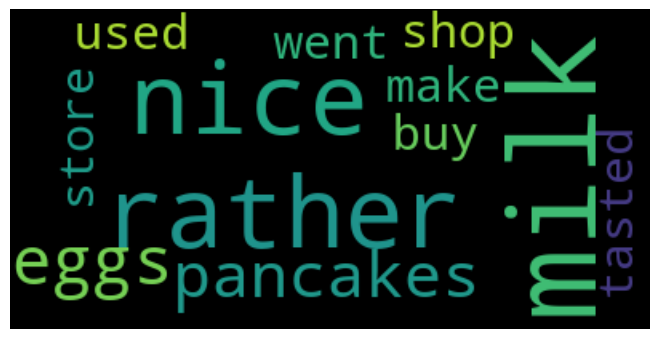

In [ ]:
#importing our WordCloud Generator
from wordcloud import WordCloud
import string
import matplotlib.pyplot as plt
def Make_Word_Cloud(List,Name):
  text = " ".join(i for i in List)
  wordcloud=WordCloud().generate(text)
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.tight_layout(pad = 0)
  String=Name+".png"
  plt.savefig(String)
  #plt.show()
Test_WordCloud=["I went to the store to buy milk","The milk was rather nice","They also had eggs in the shop","I used the eggs and milk to make pancakes","The pancakes tasted rather nice"]
Make_Word_Cloud(Test_WordCloud,"Test")

In [ ]:
def Filter_Score(List):
  Total=len(List)
  ZeroCount=0
  OneCount=0
  TwoCount=0
  for i in List:
    if i==0:
      ZeroCount+=1
    elif i==1:
      OneCount+=1
    elif i==2:
      TwoCount+=1
  ZeroCount=ZeroCount/Total
  OneCount=OneCount/Total
  TwoCount=TwoCount/Total
  return ZeroCount,OneCount,TwoCount


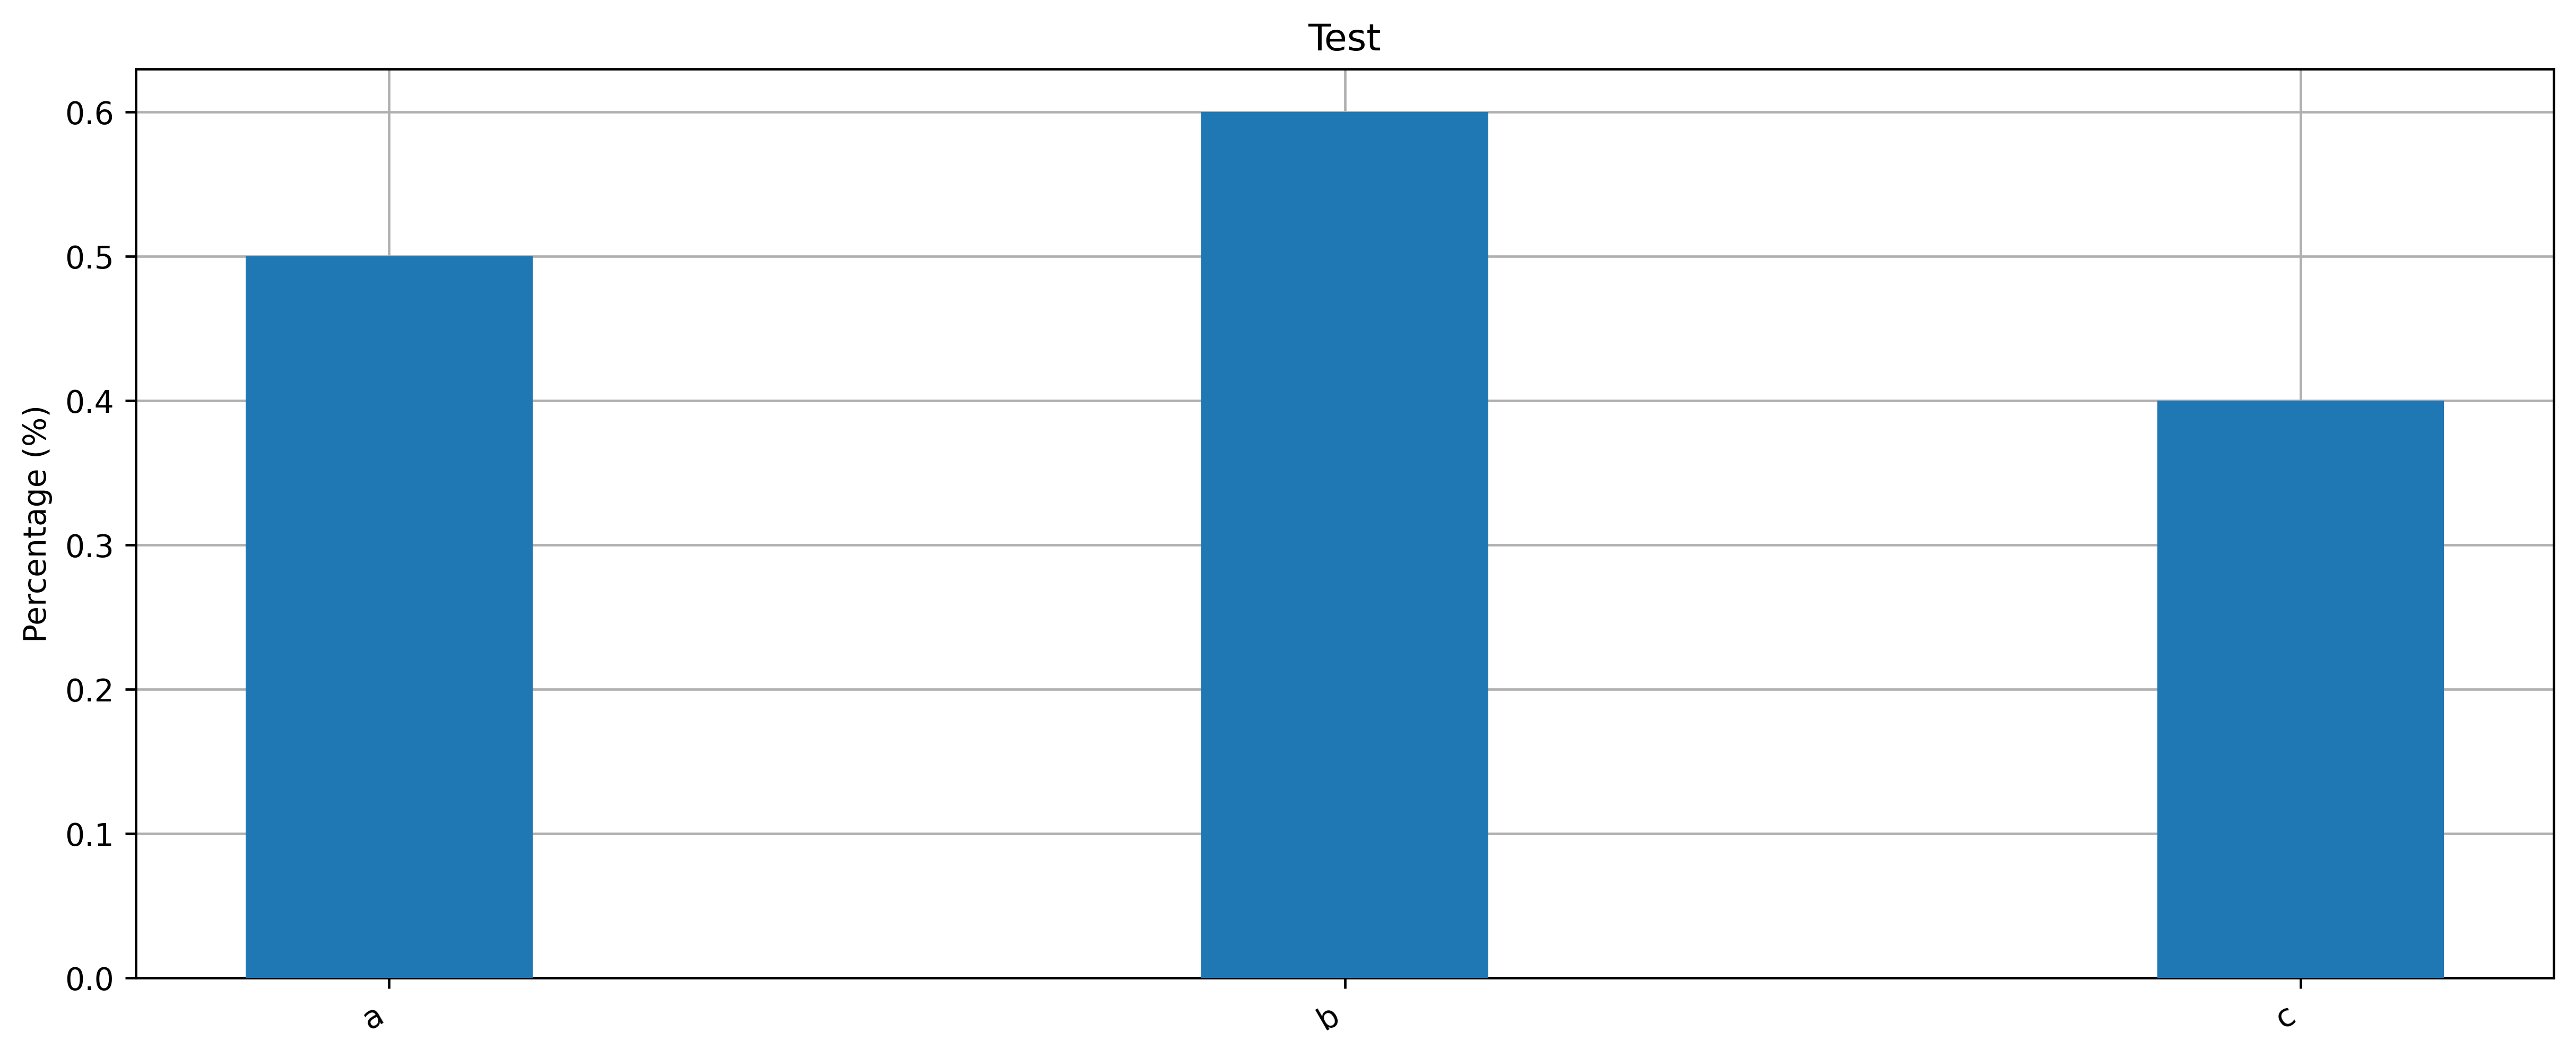

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def Bar(Numbers,Names,Title):
  for i in Numbers:
    i=i*100
  fig, ax = plt.subplots (figsize=(14,6), dpi=420)
  plt.title(Title)
  Numbers=np.array(Numbers)
  fig.autofmt_xdate()
  plt.autoscale()
  ax.grid(True,zorder=-0.5)
  ax.bar(Names,Numbers,zorder=5,width=0.3)
  plt.ylabel('Percentage (%)')
  String=Title+".png"
  plt.savefig(String)
  plt.show()
Numbers=[0.5,0.6,0.4]
Names=["a","b","c"]
Title="Test"
Bar(Numbers,Names,Title)

In [ ]:
!pip install stop-words
from stop_words import get_stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Loading the StopWord
import string
import time
STOPWORDS=[]
STOPWORDS=get_stop_words('dutch')
def Filter_Stopwords(List):
  Filtered_List=[]
  for i in List:
    i=str(i)
    i=i.lower()
    i=re.sub(r'http\S+', '',i)
    i=re.sub(r'bit\.ly\S+', '',i)
    i=re.sub(r"\S+\.nl\S+",r" ",i)
    '''
    This should work as a larger, compound regex, but it doesn't. I am unsure why
    Thus we have an inefficient, brute-force solution. But it works
    If it ain't broke, don't fix it
    '''
    i=re.sub(r"\#",r" ",i);i=re.sub(r"\.",r" ",i)
    i=re.sub(r"\!",r" ",i);i=re.sub(r"\“",r" ",i)
    i=re.sub(r"[.]+",r" ",i);i=re.sub(r"\:",r" ",i)
    i=re.sub(r"\#",r" ",i);i=re.sub(r"\?",r" ",i)
    i=re.sub(r"\"",r" ",i);i=re.sub(r"\(",r" ",i)
    i=re.sub(r"\)",r" ",i);i=re.sub(r"…",r" ",i)
    i=re.sub(r"\,",r" ",i);i=re.sub(r"\+",r" ",i)
    i=re.sub(r"\*",r" ",i);i=re.sub(r"\&",r" ",i)
    j=i.split()
    j_2=j.copy()
    for k in j_2:
      if k in STOPWORDS:
        #print(k, "IN STOPWORDS")
        try:
          j.remove(k)
        except:
          pass
    sentence = " ".join(j)
    Filtered_List.append(sentence)
  return Filtered_List
HMMM=["Dat ik moet en hebben met","Als ik niet dan moet ik wel zonder"]
HM=Filter_Stopwords(HMMM)
print(HM)

['', 'wel']


In [ ]:
#Debugging Filter
df=pd.read_csv(r"/DIR/CSVs_CrowdTangle/VVD.csv")
Processed=[]
messages=df["message"].tolist()
MESSAGE=Filter_Stopwords(messages)

In [ ]:
import re
File_List=['VVD.csv','SP.csv','SGP.csv','Wopke-Hoekstra (CDA).csv','Thierry-Baudet (FVD).csv','Mark-Rutte-VVD.csv','Joost-Eerdmans (JA21).csv',
'Sigrid-Kaag (D66).csv','Mirjam-Bikker (CU).csv','Kees-van-der-Staaij (SGP).csv','JA21.csv','Jesse-Klaver (Groenlinks).csv','GroenLinks.csv','Farid-Azarkan (DENK).csv',
'D66.csv','ChristenUnie.csv','Attje-Kuiken (PvdA).csv','CDA.csv','PvdD.csv','PvdA.csv','Volt-Nederland.csv',
'Lilian-Marijnissen (SP).csv','FVD.csv','Geert-Wilders (PVV).csv','DENK.csv','BIJ1.csv','BBB.csv']
Names=[]
for i in File_List:
  i=re.sub(r"\.csv",r"",i)
  Names.append(i)

In [ ]:
import pandas as pd
def Save_Column(csv,List,name):
  #print(csv,List,name)
  df1=pd.read_csv(csv)
  #print(df.head())
  df1[name]=List
  df1.to_csv(csv,index=False)
  #print(df1.head())
  print(name,"saved!")

In [ ]:

def create_csv(csv,col,List):
  #print(csv,col,List)
  df=pd.DataFrame(List,columns=[col])
  #print(df.head())
  df.to_csv(csv)

In [ ]:
#To debug specific CSVs
df=pd.read_csv(r"/DIR/CSVs_CrowdTangle/Mirjam-Bikker (CU).csv")
message=df['message']
date=df['date']
Messages=List_Relevant_Messages(date,message,Names)
message=remove_emojis(Messages)
print(len(Messages),len(message))
Sentiment=sentiment_pred_score(message)
Save_Column(r"/DIR/Derived_Datasets/Mirjam-Bikker (CU).csv",Sentiment,"Sentiment")
Hate=hatespeech_pred_score(message)

14 14
Sentiment saved!


OK UP UNTIL UNPACKING
Sentiment saved!
VVD STILL WORKS UNTIL THE HATE SPEECH PREDICTION
VVD STILL WORKS UNTIL THE SAVEDIR
Hate saved!
_________________________________________________
OK UP UNTIL UNPACKING
Sentiment saved!
SP STILL WORKS UNTIL THE HATE SPEECH PREDICTION
SP STILL WORKS UNTIL THE SAVEDIR
Hate saved!
_________________________________________________
OK UP UNTIL UNPACKING
Sentiment saved!
SGP STILL WORKS UNTIL THE HATE SPEECH PREDICTION
SGP STILL WORKS UNTIL THE SAVEDIR
Hate saved!
_________________________________________________
OK UP UNTIL UNPACKING
Sentiment saved!
Wopke-Hoekstra (CDA) STILL WORKS UNTIL THE HATE SPEECH PREDICTION
Wopke-Hoekstra (CDA) STILL WORKS UNTIL THE SAVEDIR
Hate saved!
_________________________________________________
OK UP UNTIL UNPACKING
Sentiment saved!
Thierry-Baudet (FVD) STILL WORKS UNTIL THE HATE SPEECH PREDICTION
Thierry-Baudet (FVD) STILL WORKS UNTIL THE SAVEDIR
Hate saved!
_________________________________________________
OK UP UNTIL UN

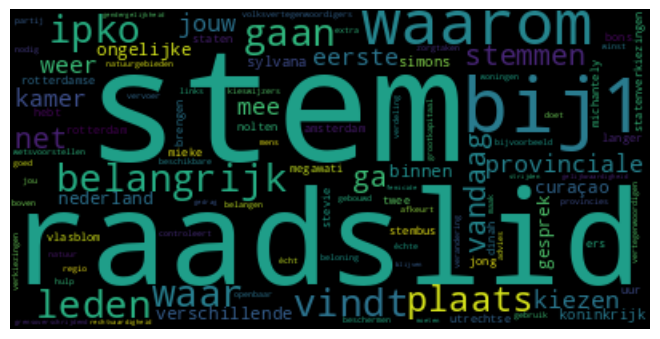

In [ ]:
#First Stage of Analysis
LenMessages=[]
NegativeSentiment=[]
NeutralSentiment=[]
PositiveSentiment=[]
HateSpeech=[]
HatentSpeech=[]
SaveDir=r"/DIR/Derived_Datasets/"
for i,j in zip(File_List,Names):
  string=DIR+i
  savedir=SaveDir+i
  df=pd.read_csv(string)
  date=df['date']
  message=df['message']
  #print(len(date),len(message))
  print("OK UP UNTIL UNPACKING")
  try:
    Messages=List_Relevant_Messages(date,message,Names) #Filters the messages
    LenMessages.append(len(Messages)) #Registers the amount of messages captured
    message=remove_emojis(Messages) #removes the emojis from messages
    create_csv(savedir,"Message",message)
    Sentiment=sentiment_pred_score(message) #predicts the sentiment score of a given facebook post
    Save_Column(savedir,Sentiment,"Sentiment")
    Negative,Neutral,Positive=Filter_Score(Sentiment) #Calculates percentages of scores
    NegativeSentiment.append(Negative);NeutralSentiment.append(Neutral);PositiveSentiment.append(Positive) #appends the scores the the relevant lists
    Filtered=Filter_Stopwords(message) #Removes stopwords
    Make_Word_Cloud(Filtered,j) #Generates wordclouds
    Hate=hatespeech_pred_score(message) #predicts whether a facebook post is hate speech
    Save_Column(savedir,Hate,"Hate")
    Non_Hate,Hate,MeansNothing=Filter_Score(Hate) #calculates percentages of scores
    HatentSpeech.append(Non_Hate);HateSpeech.append(Hate)#appends to relevant lists
    print("_________________________________________________")
  except:
    print("Welp, some process has gone wrong",j)
    NegativeSentiment.append(0);NeutralSentiment.append(0);PositiveSentiment.append(0) #appends the scores the the relevant lists
    HatentSpeech.append(0);HateSpeech.append(0)#appends to relevant lists
    #Names.remove(j)
Save_Column(r"/DIR/ParamData.csv",LenMessages,"Length of Messages")


In [ ]:
import numpy as np
NegativeVars=[]
NeutralVars=[]
PositiveVars=[]
AverageSentiment=[]
HateVars=[]
NonHateVars=[]
AverageHate=[]
#HateList=[]
ListOfLists=[NegativeVars,NeutralVars,PositiveVars,AverageSentiment,HateVars,NonHateVars,AverageHate]
ListOfValues=["Negative%","Neutral%","Positive%","AverageSentiment","Hate%","NonHate%","AverageHate"]
for i,j in zip(File_List,Names):
  try:
    string=r"/DIR/Derived_Datasets/"+i
    df=pd.read_csv(string)
    Sentiment=df["Sentiment"]
    HateCol=df["Hate"]
    SentimentSum=sum(Sentiment)/len(Sentiment)
    HateSum=sum(HateCol)/len(HateCol)
    AverageSentiment.append(SentimentSum);AverageHate.append(HateSum)
    Negative=0
    Neutral=0
    Positive=0
    Hate=0
    NonHate=0
    for i in Sentiment:
      if i==0:
        Negative+=1
      elif i==1:
        Neutral+=1
      elif i==2:
        Positive+=1
    NegativeVars.append(Negative/len(Sentiment));NeutralVars.append(Neutral/len(Sentiment));PositiveVars.append(Positive/len(Sentiment))
    for i in HateCol:
      if i==0:
        NonHate+=1
      elif i==1:
        Hate+=1
    HateVars.append(Hate/len(HateCol));NonHateVars.append(NonHate/len(HateCol))
  except:
    for i in ListOfLists:
      i.append(np.nan)
for i,j in zip (ListOfLists,ListOfValues):
  Save_Column(r"/DIR/ParamData.csv",i,j)



Negative% saved!
Neutral% saved!
Positive% saved!
AverageSentiment saved!
Hate% saved!
NonHate% saved!
AverageHate saved!


In [ ]:
Positive=Bar(PositiveSentiment,Names,"Percentage of posts classified as negative sentiment") #this seems inverted, I don't know why
Neutral=Bar(NeutralSentiment,Names,"Percentage of posts classified as neutral sentiment")
Negative=Bar(NegativeSentiment,Names,"Percentage of posts classified as positive sentiment") #also inverted, also don't know why
Hate=Bar(HateSpeech,Names,"Percentage of posts classified as hate speech")
NonHate=Bar(HatentSpeech,Names,"Percentage of posts classified as non-hate speech")

In [ ]:
import pandas as pd
import re
import time;import datetime
import statistics
upper_range=time.mktime(datetime.datetime.strptime('2023-03-15 23:59:59', "%Y-%m-%d %H:%M:%S").timetuple())
lower_range=time.mktime(datetime.datetime.strptime('2022-12-15 23:59:59', "%Y-%m-%d %H:%M:%S").timetuple())
FollowDiffTotalAll=[]
ListofVars=["Score","totalInteraction","Like","Comment","Share","Love","Wow","Sad","Angry","Care","PostVideoCount"]
ListOfLists=[]
for i in ListofVars:
   str1="Average"+i
   ListOfLists.append(str1)
   str2="Average"+i+"Min"
   ListOfLists.append(str2)
   str3="Average"+i+"Max"
   ListOfLists.append(str3)
   str4="Average"+i+"Std"
   ListOfLists.append(str4)
#There is definitely a more efficient system for this.
AverageScore=[];ScoreMin=[];ScoreMax=[];ScoreStd=[]
AveragetotalInteraction=[];totalInteractionMin=[];totalInteractionMax=[];totalInteractionStd=[]
AverageLike=[];LikeMin=[];LikeMax=[];LikeStd=[]
AverageComment=[];CommentMin=[];CommentMax=[];CommentStd=[]
AverageShare=[];ShareMin=[];ShareMax=[];ShareStd=[]
AverageLove=[];LoveMin=[];LoveMax=[];LoveStd=[]
AverageWow=[];WowMin=[];WowMax=[];WowStd=[]
AverageHaha=[];HahaMin=[];HahaMax=[];HahaStd=[]
AverageSad=[];SadMin=[];SadMax=[];SadStd=[]
AverageAngry=[];AngryMin=[];AngryMax=[];AngryStd=[]
AverageCare=[];CareMin=[];CareMax=[];CareStd=[]
AveragePostVideoCount=[];PostVideoCountMin=[];PostVideoCountMax=[];PostVideoCountStd=[]

Score=[AverageScore,ScoreMin,ScoreMax,ScoreStd]
totalInteraction=[AveragetotalInteraction,totalInteractionMin,totalInteractionMax,totalInteractionStd]
Like=[AverageLike,LikeMin,LikeMax,LikeStd]
Comment=[AverageComment,CommentMin,CommentMax,CommentStd]
Share=[AverageShare,ShareMin,ShareMax,ShareStd]
Love=[AverageLove,LoveMin,LoveMax,LoveStd]
Wow=[AverageWow,WowMin,WowMax,WowStd]
Haha=[AverageHaha,HahaMin,HahaMax,HahaStd]
Sad=[AverageSad,SadMin,SadMax,SadStd]
Angry=[AverageAngry,AngryMin,AngryMax,AngryStd]
Care=[AverageCare,CareMin,CareMax,CareStd]
PostVideoCount=[AveragePostVideoCount,PostVideoCountMin,PostVideoCountMax,PostVideoCountStd]

All_Data=[Score,totalInteraction,Like,Comment,Share,Love,Wow,Haha,Sad,Angry,PostVideoCount]

DIR="/DIR/CSVs_CrowdTangle/"
SaveDir=r"/DIR/Derived_Datasets/"
def Avg_min_max_std(List,ListofListContainers):
  CleanedList=[]
  for i in List:
    i=str(i)
    i=re.sub(r"\,",r"",i)
    i=float(i)
    CleanedList.append(i)
  Average=sum(CleanedList)/len(CleanedList)
  minimum=min(CleanedList)
  maximum=max(CleanedList)
  STD=statistics.pstdev(CleanedList)
  ListofListContainers[0].append(Average)
  ListofListContainers[1].append(minimum)
  ListofListContainers[2].append(maximum)
  ListofListContainers[3].append(STD)

for i,j in zip(File_List,Names):
  string=DIR+i
  savedir=SaveDir+i
  df=pd.read_csv(string)
  print(i)
  Follows=df["Followers at Posting"]
  Date=df['date']
  score=df['score']
  TOTALINTERACTION=df['totalInteraction']
  LIKE=df['statistics.actual.likeCount']
  COMMENT=df['statistics.actual.commentCount']
  SHARE=df['statistics.actual.shareCount']
  LOVE=df['statistics.actual.loveCount']
  WOW=df['statistics.actual.wowCount']
  HAHA=df['statistics.actual.hahaCount']
  SAD=df['statistics.actual.sadCount']
  ANGRY=df['statistics.actual.angryCount']
  CARE=df['statistics.actual.careCount']
  POSTVIDEOCOUNT=df['statistics.actual.videoPostViewCount']

  FollowsRanged=[];ScoresRanged=[];InteractionRanged=[];LikeRanged=[]
  CommentRanged=[];ShareRanged=[];LoveRanged=[];WowRanged=[]
  HahaRanged=[];SadRanged=[];AngryRanged=[];CareRanged=[]
  VideoCountRanged=[]
  Parsables=[ScoresRanged,InteractionRanged,LikeRanged,CommentRanged,ShareRanged,LoveRanged,WowRanged,HahaRanged,SadRanged,AngryRanged,CareRanged,VideoCountRanged]
  for i,j,k,l,m,n,o,p,q,r,s,t,u,v in zip(Date,Follows,score,TOTALINTERACTION,LIKE,COMMENT,SHARE,LOVE,WOW,HAHA,SAD,ANGRY,CARE,POSTVIDEOCOUNT): #Efficiency at its finest
      i=re.sub(r" EST",r"",i)
      i=re.sub(r" EDT",r"",i)
      i=time.mktime(datetime.datetime.strptime(i, "%Y-%m-%d %H:%M:%S").timetuple())
      if i < upper_range:
        if i > lower_range:
          #This could be looped better
          FollowsRanged.append(j)
          ScoresRanged.append(k)
          InteractionRanged.append(l)
          LikeRanged.append(m)
          CommentRanged.append(n)
          ShareRanged.append(o)
          LoveRanged.append(p)
          WowRanged.append(q)
          HahaRanged.append(r)
          SadRanged.append(s)
          AngryRanged.append(t)
          CareRanged.append(u)
          VideoCountRanged.append(v)
  for i in Parsables:
    try:
      FollowsDiff=FollowsRanged[0]-FollowsRanged[-1]
      FollowDiffTotalAll.append(FollowsDiff)
      for i,j in zip(Parsables,All_Data):
        Avg_min_max_std(i,j)
    except:
      FollowDiffTotalAll.append(0)
      for i in All_Data:
        for j in i:
          j.append(0)
create_csv(r"/DIR/Derived_Datasets/ParamData.csv","Difference in Followers",FollowDiffTotalAll)
NamesExpanded=[] #this is a work around for some incorrect loop somewhere.
for i in Names:
  for j in range(0,12):
    NamesExpanded.append(i)
Save_Column(r"/DIR/ParamData.csv",NamesExpanded,"Party")
Counter=0
for i in All_Data:
  for j in i:
    Save_Column(r"/DIR/ParamData.csv",j,ListOfLists[Counter])
    Counter+=1
df=pd.read_csv(r"/DIR/ParamData.csv")
df=df.drop_duplicates(subset=['Party'])
df.to_csv(r"/DIR/ParamData.csv")

